In [ ]:
!pip install tensorflow

In [ ]:
# To install Keras
!pip install -q tensorflow keras keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 38.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras_cv

print("TensorFlow version:", tf.__version__)
print("KerasCV version:", keras_cv.__version__)


TensorFlow version: 2.18.0
KerasCV version: 0.9.0


In [ ]:
  import kagglehub
  import tensorflow as tf
  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  # Set image size and batch size
  IMG_SIZE = (224, 224)
  BATCH_SIZE = 32

  # 📥 Download dataset
  DATA_PATH = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

  # ✅ Image data preprocessing
  datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2
  )

  # ✅ Training data
  train_data = datagen.flow_from_directory(
      DATA_PATH,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode='categorical',
      subset='training',
      shuffle=True
  )

  # ✅ Validation data
  val_data = datagen.flow_from_directory(
      DATA_PATH,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode='categorical',
      subset='validation',
      shuffle=False  # Important for evaluation
  )


Found 5619 images belonging to 2 classes.
Found 1404 images belonging to 2 classes.


### Label Extraction Code

In [ ]:
import numpy as np

# Collect all validation images and true labels
y_true = []
val_images = []

for batch in val_data:
    images, labels = batch
    val_images.extend(images)
    y_true.extend(np.argmax(labels, axis=1))

    # Stop when we've collected all validation images
    if len(val_images) >= val_data.samples:
        break

val_images = np.array(val_images)
y_true = np.array(y_true)

print("✅ Collected validation data:", val_images.shape, y_true.shape)


✅ Collected validation data: (1404, 224, 224, 3) (1404,)


# 🧠 Step 3: Train the CNN-Only Baseline Model
#### This will serve as your baseline architecture (local features only — no transformer).

In [ ]:
from tensorflow.keras import layers, models

def build_cnn_only(input_shape=(224, 224, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Build, compile, and train CNN model
cnn_model = build_cnn_only()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=50
)

# Save the model for later evaluation
cnn_model.save("ablation_models/cnn_only.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 50s 247ms/step - accuracy: 0.7948 - loss: 0.5152 - val_accuracy: 0.8134 - val_loss: 0.4953
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.8046 - loss: 0.5009 - val_accuracy: 0.8134 - val_loss: 0.4812
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.8138 - loss: 0.4831 - val_accuracy: 0.8134 - val_loss: 0.4832
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 171ms/step - accuracy: 0.8131 - loss: 0.4828 - val_accuracy: 0.8134 - val_loss: 0.4814
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.8138 - loss: 0.4800 - val_accuracy: 0.8134 - val_loss: 0.4830
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.8072 - loss: 0.4875 - val_accuracy: 0.8134 - val_loss: 0.4909
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.8142 - loss: 0.4757 - val_accuracy: 0.8134 - val_loss: 0.4838
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.8123 - loss: 0

### ✅ Code to Plot Training vs Validation Accuracy and Loss:

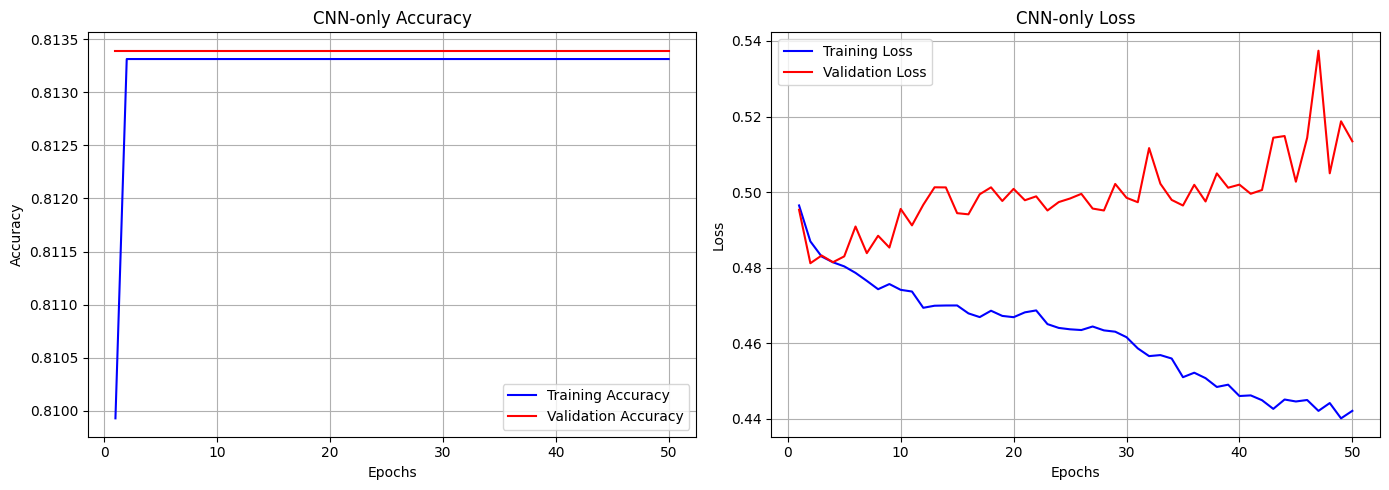

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Save the figure (for adding to paper)
    plt.tight_layout()
    plt.savefig(f"{model_name.replace(' ', '_').lower()}_training_plot.png", dpi=300)
    plt.show()

# Call the function with your CNN training history
plot_training_history(history_cnn, model_name="CNN-only")


# 🧠 Step 4: Train the ViT-Only Model
### This model captures global context using a Vision Transformer (ViT), without CNNs.

### ✅ Step 4.1: Define Patches and PatchEncoder Layers

In [ ]:
from tensorflow.keras import layers

# Patch creation layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

# Patch encoder
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.position_embedding.input_dim, delta=1)
        positions = tf.expand_dims(positions, axis=0)
        positions = tf.tile(positions, [batch_size, 1])
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


### ✅ Step 4.2: Define and Compile the ViT Model

In [ ]:
from tensorflow import keras

def create_vit_classifier(input_shape=(224, 224, 3), num_classes=2,
                          patch_size=16, projection_dim=64,
                          transformer_layers=8, num_heads=4,
                          mlp_head_units=[128, 64]):

    inputs = layers.Input(shape=input_shape)

    patches = Patches(patch_size)(inputs)
    num_patches = (input_shape[0] // patch_size) ** 2
    encoded = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, encoded])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp = keras.Sequential([
            layers.Dense(4 * projection_dim, activation=tf.nn.gelu),
            layers.Dense(projection_dim),
        ])
        x4 = mlp(x3)
        encoded = layers.Add()([x4, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded)
    representation = layers.Flatten()(representation)
    for units in mlp_head_units:
        representation = layers.Dense(units, activation=tf.nn.gelu)(representation)
        representation = layers.Dropout(0.1)(representation)

    outputs = layers.Dense(num_classes, activation='softmax')(representation)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

vit_model = create_vit_classifier()
vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### ✅ Step 4.3: Train and Save the ViT Model

In [ ]:
history_vit = vit_model.fit(
    train_data,
    validation_data=val_data,
    epochs=100
)

vit_model.save("ablation_models/vit_only.h5")


Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 236ms/step - accuracy: 0.7379 - loss: 1.4847 - val_accuracy: 0.8134 - val_loss: 0.4851
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.8219 - loss: 0.4904 - val_accuracy: 0.8134 - val_loss: 0.4816
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.8092 - loss: 0.5018 - val_accuracy: 0.8134 - val_loss: 0.4821
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.8175 - loss: 0.4792 - val_accuracy: 0.8134 - val_loss: 0.4825
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.8088 - loss: 0.4881 - val_accuracy: 0.8134 - val_loss: 0.4814
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.8144 - loss: 0.4799 - val_accuracy: 0.8134 - val_loss: 0.4813
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.8134 - loss: 0.4821 - val_accuracy: 0.8134 - val_loss: 0.4815
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.8097 -

### ✅ Code to Plot Training vs Validation Accuracy and Loss: fro vit only

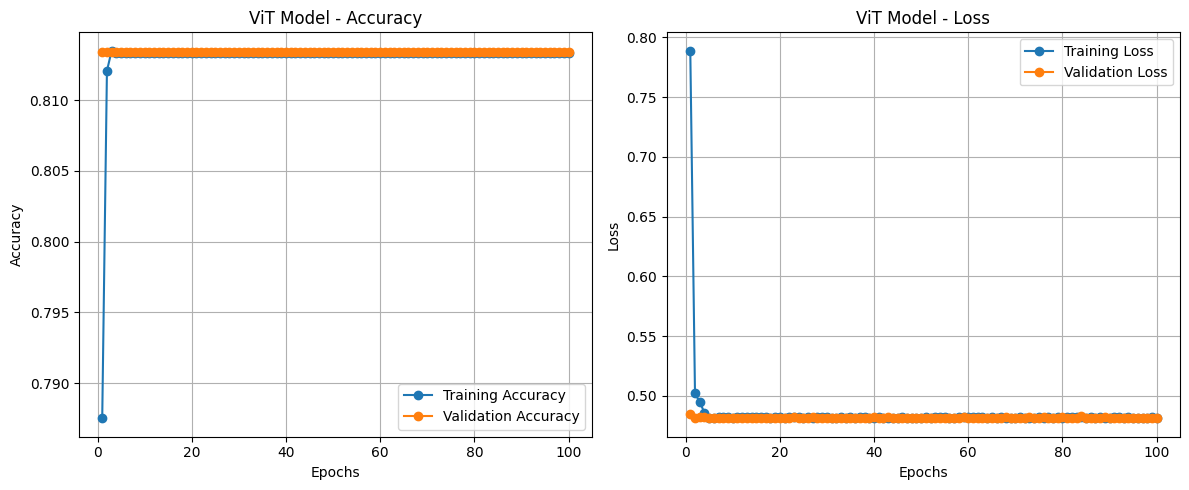

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from history object
acc = history_vit.history['accuracy']
val_acc = history_vit.history['val_accuracy']
loss = history_vit.history['loss']
val_loss = history_vit.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ViT Model - Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ViT Model - Loss')
plt.legend()
plt.grid(True)

# Save and show
plt.tight_layout()
plt.savefig("vit_model_accuracy_loss.png", dpi=300)
plt.show()

#🧠 Step 5: Build and Train the Hybrid CNN + ViT Model
#### This model combines:
####    ->CNN Branch → Local feature extraction
####    ->ViT Branch → Global context extraction
####    ->No Grad-CAM/XAI yet — just the hybrid model itself.

### ✅ Step 5.1: Define the Hybrid Architecture

In [ ]:
from tensorflow.keras import layers, Model

def create_hybrid_cnn_vit(input_shape=(224, 224, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)

    # 🔹 CNN Branch
    x_cnn = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x_cnn = layers.MaxPooling2D((2, 2))(x_cnn)
    x_cnn = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x_cnn)
    x_cnn = layers.MaxPooling2D((2, 2))(x_cnn)
    x_cnn = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="last_cnn_layer")(x_cnn)
    x_cnn = layers.GlobalAveragePooling2D()(x_cnn)

    # 🔸 ViT Branch
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) ** 2
    patches = Patches(patch_size)(inputs)
    encoded = PatchEncoder(num_patches, projection_dim=64)(patches)

    for _ in range(4):  # Simpler transformer block for hybrid
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded)
        attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x1, x1)
        x2 = layers.Add()([attn_output, encoded])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp = keras.Sequential([
            layers.Dense(4 * 64, activation='gelu'),
            layers.Dense(64),
        ])
        encoded = layers.Add()([mlp(x3), x2])

    x_vit = layers.LayerNormalization(epsilon=1e-6)(encoded)
    x_vit = layers.Flatten()(x_vit)

    # 🔗 Fusion
    combined = layers.Concatenate()([x_cnn, x_vit])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.3)(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs, outputs)
    return model


### ✅ Step 5.2: Compile and Train the Hybrid Model

In [ ]:
hybrid_model = create_hybrid_cnn_vit()
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_hybrid = hybrid_model.fit(
    train_data,
    validation_data=val_data,
    epochs=500
)
hybrid_model.save("ablation_models/hybrid_cnn_vit.h5")


Epoch 1/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.7846 - loss: 0.6182 - val_accuracy: 0.8134 - val_loss: 0.4839
Epoch 2/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.8117 - loss: 0.4975 - val_accuracy: 0.8134 - val_loss: 0.4944
Epoch 3/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.8111 - loss: 0.4913 - val_accuracy: 0.8134 - val_loss: 0.4918
Epoch 4/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.8190 - loss: 0.4781 - val_accuracy: 0.8134 - val_loss: 0.4911
Epoch 5/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.8205 - loss: 0.4673 - val_accuracy: 0.8134 - val_loss: 0.4946
Epoch 6/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.8064 - loss: 0.4793 - val_accuracy: 0.8134 - val_loss: 0.4924
Epoch 7/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.8144 - loss: 0.4627 - val_accuracy: 0.8134 - val_loss: 0.4971
Epoch 8/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.8067 -

## ✅ Plot Training vs Validation Accuracy and Loss (Hybrid CNN + ViT)

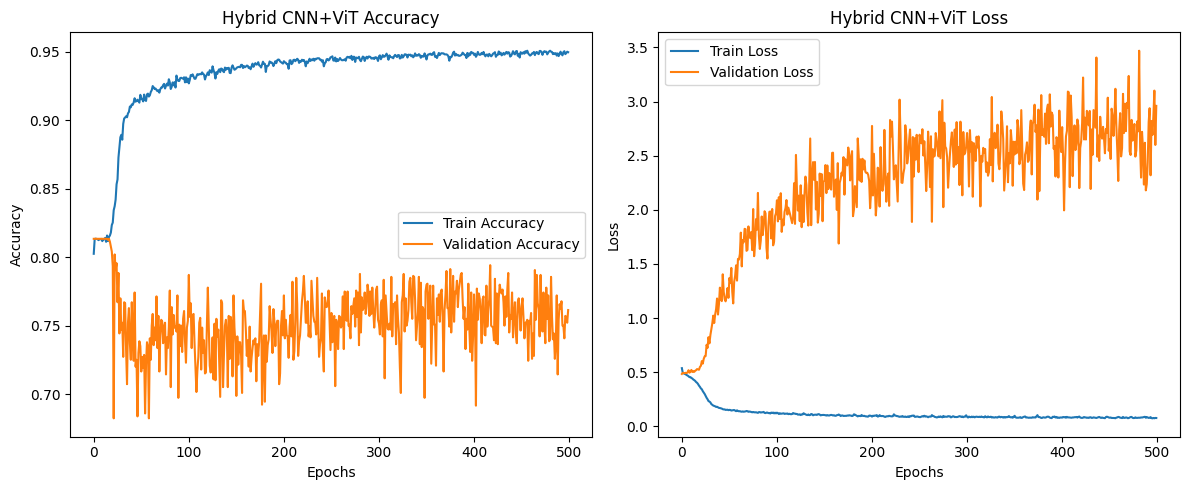

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid CNN+ViT Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Hybrid CNN+ViT Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# ✅ Metric table comparing models (Accuracy, Precision, Recall, F1)
### Here's the full code to compute Accuracy, Precision, Recall, and F1 Score for all three models: CNN-only, ViT-only, and Hybrid (CNN + ViT).

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, val_data, model_name="Model"):
    y_true = []
    y_pred = []

    for images, labels in val_data:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels, axis=1))       # assuming labels are one-hot encoded
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n{model_name} Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Evaluate CNN-only model
evaluate_model(cnn_model, val_data, model_name="CNN-only")

# Evaluate ViT-only model
evaluate_model(vit_model, val_data, model_name="ViT-only")

# Evaluate Hybrid model (CNN + ViT)
evaluate_model(hybrid_model, val_data, model_name="Hybrid CNN + ViT")


NameError: name 'cnn_model' is not defined

# 🧠 Step 6: Grad-CAM for the Hybrid CNN + ViT Model
#### We’ll apply Grad-CAM on the CNN branch (last convolutional layer) to generate heatmaps that show what parts of the MRI image influenced the model's decision.

### ✅ Step 6.1: Grad-CAM Utility Function

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)

    # Mean intensity of the gradient over the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


### ✅ Step 6.2: Visualize Heatmap on an MRI Image

In [ ]:
import cv2

def display_gradcam(model, image, label, class_names, last_conv_layer_name="last_cnn_layer"):
    # Expand dims for batch
    img_array = np.expand_dims(image, axis=0)

    # Get heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Superimpose on image
    img = image.copy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + (img * 255).astype(np.uint8)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Input Image\nLabel: {class_names[label]}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Overlay")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


### ✅ Step 6.3: Run Grad-CAM on One Sample Image

In [ ]:
# Choose one image from validation set
sample_index = 0
sample_img = val_images[sample_index]
sample_label = y_true[sample_index]

# Define your class names (adjust if needed)
class_names = ["No Tumor", "Tumor"]

# Visualize
display_gradcam(model=hybrid_model, image=sample_img, label=sample_label, class_names=class_names)


## ✅ Grad-CAM Visualizations (Loop Version) ==> for 6 Sample
#### Grad-CAM Visuals (6 samples)	✅ display_gradcam() in a loop
#### Grad-CAM PNGs for paper	✅ save_gradcam_overlay() function
#### ROC Curve	✅ roc_curve() + auc() plot
#### Classification Report	✅ classification_report() table

In [ ]:
# 🔁 Show Grad-CAM on 6 validation samples
for i in range(6):
    sample_img = val_images[i]
    sample_label = y_true[i]

    print(f"\n🔍 Grad-CAM for Sample {i+1} — Label: {class_names[sample_label]}")
    display_gradcam(
        model=hybrid_model,
        image=sample_img,
        label=sample_label,
        class_names=class_names
    )


## ✅ [Optional] Save Grad-CAM Results as PNGs for Paper

In [ ]:
def save_gradcam_overlay(model, image, label, class_names, filename, last_conv_layer_name="last_cnn_layer"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    img_array = np.expand_dims(image, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    img = image.copy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + (img * 255).astype(np.uint8)

    plt.figure(figsize=(6, 4), dpi=300)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Overlay\nLabel: {class_names[label]}")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"📸 Saved Grad-CAM to: {filename}")


In [ ]:
# 🔽 Save 6 Grad-CAM overlays
for i in range(6):
    sample_img = val_images[i]
    sample_label = y_true[i]
    save_gradcam_overlay(
        model=hybrid_model,
        image=sample_img,
        label=sample_label,
        class_names=class_names,
        filename=f"ablation_results/gradcam_sample_{i+1}.png"
    )


# ✅ Additional Evaluation for Paper (Optional But Useful)

## 1. ROC Curve for Binary Classification

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = hybrid_model.predict(val_images, verbose=0)[:, 1]  # Probability for "Tumor" class

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5), dpi=300)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – CNN + ViT Hybrid Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ablation_results/roc_curve_hybrid.png", dpi=300)
plt.show()


## 2. Classification Report in Tabular Format

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

y_pred = np.argmax(hybrid_model.predict(val_images, verbose=0), axis=1)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Save or display
print(df_report)
df_report.to_csv("ablation_results/classification_report_hybrid.csv")
